In [1]:
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import dask.dataframe as dd
import json
import sys
import time
import pylab as pl
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait
%matplotlib inline
warnings.filterwarnings('ignore')

## Lendo base de dados em CSV

In [2]:
df = pd.read_csv('1429_1.csv')
df[['asins', 'name', 'categories', 'reviews.text', 'reviews.title']].take([0,4000, 14600, 20000, 31345])

,asins,name,categories,reviews.text,reviews.title
0,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",This product so far has not disappointed. My c...,Kindle
4000,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Fire Tablets,Tablets,Computers & Tablets,All T...",This is a good kids 1st. Tablet and for a pric...,good price for a kids 1st tablet
14600,B018Y229OU,Brand New Amazon Kindle Fire 16gb 7 Ips Displa...,"Fire Tablets,Tablets,Computers & Tablets,All T...",Great purchase my grandson Alek loves his tabl...,Grandson loves it
20000,B00OQVZDJM,Amazon Kindle Paperwhite - eBook reader - 4 GB...,"Walmart for Business,Office Electronics,Tablet...",While reading might be a bit easier on the Pap...,Replaced with Kindle Fire
31345,B00U3FPN4U,NaN,"Back To College,College Electronics,College Tv...",Does what's advertised! Great with 4K handling...,It's a Fire TV


## Análise

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
id                      34660 non-null object
name                    27900 non-null object
asins                   34658 non-null object
brand                   34660 non-null object
categories              34660 non-null object
keys                    34660 non-null object
manufacturer            34660 non-null object
reviews.date            34621 non-null object
reviews.dateAdded       24039 non-null object
reviews.dateSeen        34660 non-null object
reviews.didPurchase     1 non-null object
reviews.doRecommend     34066 non-null object
reviews.id              1 non-null float64
reviews.numHelpful      34131 non-null float64
reviews.rating          34627 non-null float64
reviews.sourceURLs      34660 non-null object
reviews.text            34659 non-null object
reviews.title           34655 non-null object
reviews.userCity        0 non-null float64
reviews.userProvince    0

### Como mostra os dados acima, existem 34660 reviews de produtos identificados, mas somente 34658 ids de produto  
### <span style="color:red">TRATAR ISSO</span>

In [4]:
df[['reviews.rating']].describe()

,reviews.rating
count,34627.000000
mean,4.584573
std,0.735653
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Agrupando produtos por média de nota de review  
Isso será usado para facilitar no cálculo da correlação de produtos mais a frente

In [5]:
products = pd.DataFrame(df.groupby('asins')['reviews.rating'].mean())

In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, B002Y27P3M to B01J4ORNHU
Data columns (total 1 columns):
reviews.rating    38 non-null float64
dtypes: float64(1)
memory usage: 656.0+ bytes


In [7]:
products.head()

,reviews.rating
asins,
B002Y27P3M,NaN
B002Y27P6Y,3.500000
B005PB2T0S,4.000000
B005PB2T2Q,3.666667
B006GWO5NE,4.875000


## Identifica quantas avaliações existem por produto e insere no dataframe

In [8]:
products['number_of_ratings'] = df.groupby('asins')['reviews.rating'].count()
products.head()

,reviews.rating,number_of_ratings
asins,,
B002Y27P3M,NaN,0
B002Y27P6Y,3.500000,10
B005PB2T0S,4.000000,5
B005PB2T2Q,3.666667,6
B006GWO5NE,4.875000,8


In [9]:
products.describe()

,reviews.rating,number_of_ratings
count,38.000000,41.000000
mean,4.411462,844.512195
std,0.568281,2142.269919
min,2.461538,0.000000
25%,4.428623,7.000000
50%,4.557075,15.000000
75%,4.705459,372.000000
max,5.000000,10966.000000


## Visualização da distribuição das notas em produtos

Text(0, 0.5, 'Número de avaliações (em milhar)')

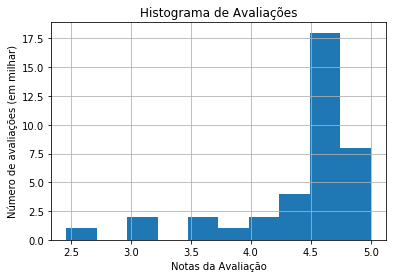

In [15]:
axarr = products['reviews.rating'].hist()
pl.title("Histograma de Avaliações")
pl.xlabel('Notas da Avaliação')
pl.ylabel('Número de avaliações (em milhar)')

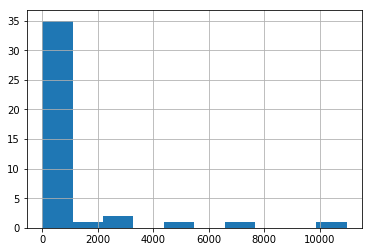

In [111]:
products['number_of_ratings'].hist()

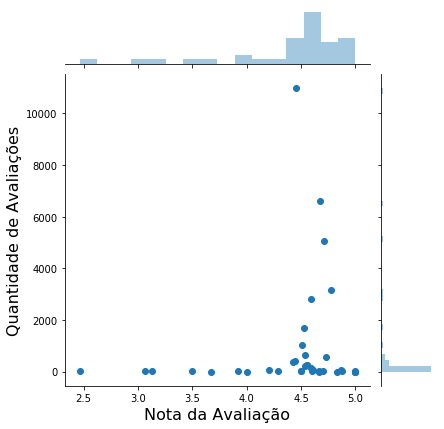

In [19]:
h = sns.jointplot(x='reviews.rating', y='number_of_ratings', data=products)

h.set_axis_labels('Nota da Avaliação', 'Quantidade de Avaliações', fontsize=16)

In [21]:
df['asins'].value_counts()

B018Y229OU               10966
B00L9EPT8O,B01E6AO69U     6619
B00U3FPN4U                5056
B00OQVZDJM                3176
B01AHB9CN2                2814
B018Y23MNM                1685
B018Y225IA                1038
B01BH83OOM                 636
B00IOY8XWQ                 580
B01J2G4VBG                 402
B00TSUGXKE                 372
B018SZT3BK                 270
B0189XYY0Q                 256
B00ZV9PXP2                 212
B01AHB9CYG                 158
B00QFQRELG                  73
B00VINDBJK                  67
B00IOYAM4I                  51
B01BFIBRIE                  30
B002Y27P3M                  19
B00QJDU3KY                  19
B01J4ORNHU                  16
B00QL1ZN3G                  15
B01AHB9C1E                  14
B00LW9XOJM                  13
B006GWO5WK                  13
B002Y27P6Y                  10
B018Y22BI4                  10
B006GWO5NE                   8
B00UH4D8G2                   8
B00X4WHP5E                   7
B018T075DC                   7
B005PB2T

In [24]:
df['asins'].size

34660

## Motor de recomendação
### Criação de uma matriz de produtos com avaliações

In [113]:
df.processed_categories = df.categories.apply(lambda row: row.split(','))
df.processed_categories.head()

0    [Electronics, iPad & Tablets, All Tablets, Fir...
1    [Electronics, iPad & Tablets, All Tablets, Fir...
2    [Electronics, iPad & Tablets, All Tablets, Fir...
3    [Electronics, iPad & Tablets, All Tablets, Fir...
4    [Electronics, iPad & Tablets, All Tablets, Fir...
Name: categories, dtype: object

In [114]:
df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

In [115]:
df = df[['name', 'asins', 'brand', 'categories', 'manufacturer', 'reviews.title', 'reviews.text']]
#df = df.drop_duplicates(subset=['asins'])
df.head()

,name,asins,brand,categories,manufacturer,reviews.title,reviews.text
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,Kindle,This product so far has not disappointed. My c...
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,very fast,great for beginner or experienced person. Boug...
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,Good!!!,I've had my Fire HD 8 two weeks now and I love...
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,Fantastic Tablet for kids,I bought this for my grand daughter when she c...


In [116]:
df['name'] = df['name'].map(lambda x: re.split(', | \s | \n', str(x).lower()))
df['categories'] = df['categories'].map(lambda x: re.split(', | \&', str(x).lower()))
df.set_index('asins', inplace=True)

In [117]:
df.head()

,name,brand,categories,manufacturer,reviews.title,reviews.text
asins,,,,,,
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,Kindle,This product so far has not disappointed. My c...
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,very fast,great for beginner or experienced person. Boug...
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,Good!!!,I've had my Fire HD 8 two weeks now and I love...
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,Fantastic Tablet for kids,I bought this for my grand daughter when she c...


In [123]:
def get_sentiment_score(review):
    if not review.get('reviews.text', False):
        review['reviews.text'] = ''
        return review
    
    try:
        document = types.Document(content=review.get('reviews.text', ''), type=enums.Document.Type.PLAIN_TEXT)
        sentiment_score = client.analyze_entity_sentiment(document=document)
        review['parsed_text'] = [entity.name for entity in sentiment_score.entities if entity.sentiment.score > 0 or not entity.sentiment.score]
    except:
        return review
     
    return review

In [124]:
def get_sentiment_score_title(review):
    if not review.get('reviews.title', False):
        review['parsed_title'] = ''
        return review
    try:
        document = types.Document(content=review.get('reviews.title', ''), type=enums.Document.Type.PLAIN_TEXT)
        sentiment_score = client.analyze_entity_sentiment(document=document)
        review['parsed_title'] = [entity.name for entity in sentiment_score.entities if entity.sentiment.score > 0 or not entity.sentiment.score] 
    except:
        return review
    
    
    return review

In [125]:
%env GOOGLE_APPLICATION_CREDENTIALS=/home/luan/tcc/creds/TTC-PLN-edde7bd554e0.json
client = language.LanguageServiceClient()

env: GOOGLE_APPLICATION_CREDENTIALS=/home/luan/tcc/creds/TTC-PLN-edde7bd554e0.json


In [126]:
#df['reviews.text'].apply(lambda row: get_sentiment_score(str(row)))
dict_dataframe = df.to_dict('records')

In [130]:
pool = ThreadPoolExecutor(50)
#parsed_text_file = open('./parsed_text_file.json', 'w+')
count = 0
success = 0
total = len(dict_dataframe)
list_of_futures = []

for item in dict_dataframe:
    count += 1
    
    if count % 400 == 0:
        time.sleep(60)
        
    #list_of_futures.append(pool.submit(get_sentiment_score, item))
    for future in list_of_futures:
        success += 1
        return_item = future.result()
        list_of_futures.remove(future)
        #parsed_text_file.write(json.dumps(return_item)+'\n')
        
    sys.stdout.write('\r{}/{}({})'.format(success, count, total))
    sys.stdout.flush()

#parsed_text_file.close()

34660/34660(34660)

In [132]:
pool = ThreadPoolExecutor(50)
#parsed_text_file = open('./parsed_text_file_title.json', 'w+')
count = 0
success = 0
total = len(dict_dataframe)
list_of_futures = []
time.sleep(60)
for item in dict_dataframe:
    count += 1
    
    if count % 400 == 0:
        time.sleep(60)
        
    #list_of_futures.append(pool.submit(get_sentiment_score_title, item))
    for future in list_of_futures:
        success += 1
        return_item = future.result()
        list_of_futures.remove(future)
        #parsed_text_file.write(json.dumps(return_item)+'\n')
        
    sys.stdout.write('\r{}/{}({})'.format(success, count, total))
    sys.stdout.flush()

#parsed_text_file.close()

34660/34660(34660)

In [26]:
open_title_file = open('./parsed_text_file_title.json', 'r')
open_text_file = open('./parsed_text_file.json', 'r')

json_data_title = []
json_data_text = []

for line in open_title_file:
    json_data_title.append(json.loads(line))
    
for line in open_text_file:
    json_data_text.append(json.loads(line))
    
df_title = pd.DataFrame.from_dict(json_data_title)
df_text = pd.DataFrame.from_dict(json_data_text)

#df = pd.merge(df_title, df_text, on='asins')
#df_title['asins']

In [27]:
df = pd.read_csv('1429_1.csv')

In [28]:
df_parsed = pd.merge(df_title[['parsed_title', 'reviews.text']], df_text[['parsed_text', 'reviews.text']], on='reviews.text')
df_parsed = pd.merge(df_parsed, df, on='reviews.text')
df_parsed.head()

,parsed_title,reviews.text,parsed_text,id,name,asins,brand,categories,keys,manufacturer,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,[Kindle],This product so far has not disappointed. My c...,"[product, children, ability, content, ease, co...",AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,...,NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Kindle,NaN,NaN,Adapter
1,[],great for beginner or experienced person. Boug...,"[beginner, person, gift]",AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,...,NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,very fast,NaN,NaN,truman
2,"[Beginner tablet, son]",Inexpensive tablet for him to use and learn on...,"[tablet, NABI, Skype]",AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,...,NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,[],I've had my Fire HD 8 two weeks now and I love...,"[Fire HD 8, tablet, running, screen, look, Mem...",AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,...,NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,Good!!!,NaN,NaN,Shacks
4,"[Tablet, kids]",I bought this for my grand daughter when she c...,"[daughter, SD card, sites, age, user, name, ca...",AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,...,NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Fantastic Tablet for kids,NaN,NaN,explore42


In [29]:
df_parsed['parsed_title'] = df_parsed['parsed_title'].apply(lambda x: ', '.join(x) if type(x) == list else '')
df_parsed['parsed_text'] = df_parsed['parsed_text'].apply(lambda x: ', '.join(x) if type(x) == list else '')

In [30]:
df_merged_title = df_parsed.groupby(['asins'])['parsed_title'].apply(', '.join).reset_index()
df_merged_text = df_parsed.groupby(['asins'])['parsed_text'].apply(', '.join).reset_index()

In [31]:
df_parsed = pd.merge(df_merged_title, df_merged_text, on='asins')
df_parsed['parsed_title'] = df_parsed['parsed_title'].apply(lambda x: x.split(','))
df_parsed['parsed_text'] = df_parsed['parsed_text'].apply(lambda x: x.split(','))
df_parsed['id'] = df_parsed['asins'].apply(lambda x: x)

In [32]:
df_parsed.set_index('asins', inplace=True)

In [33]:
df_parsed.head()

,parsed_title,parsed_text,id
asins,,,
B002Y27P3M,"[money, Worth, novels, light, E-Reader, K...","[Kindle, iPad, phone, good, page-turns, i...",B002Y27P3M
B002Y27P6Y,"[person, review, cover, protection, Kindle...","[band, reviews, people, tape, side corner,...",B002Y27P6Y
B005PB2T0S,"[viewing area, Step Down, Quality, Kindle, ...","[Kindle, leather cover, Cover, Leather, ch...",B005PB2T0S
B005PB2T2Q,"[, Slick, , , , points, deal busters]","[fan, one, DoDo Case, many, Kindle, Amazo...",B005PB2T2Q
B006GWO5NE,"[, expectation, Ships, Fires, people, rev...","[gift, computer, Kindle Fire HD, jewel, ch...",B006GWO5NE


In [34]:
df_parsed['bow'] = ''
columns = df_parsed[['parsed_text', 'parsed_title']].columns
for index, row in df_parsed.iterrows():
    words = ''
    for col in columns:
        if col not in ['brand', 'manufacturer']:
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bow'] = words
    
df_parsed.drop(columns = [col for col in df_parsed.columns if col!= 'bow'], inplace = True)

In [35]:
df_parsed.head()

,bow
asins,
B002Y27P3M,Kindle iPad phone good page-turns impress...
B002Y27P6Y,band reviews people tape side corner revi...
B005PB2T0S,Kindle leather cover Cover Leather check ...
B005PB2T2Q,fan one DoDo Case many Kindle Amazon pro...
B006GWO5NE,gift computer Kindle Fire HD jewel charger...


In [36]:
count = CountVectorizer()
count_matrix = count.fit_transform(df_parsed['bow'])

indices = pd.Series(df_parsed.index)
indices[:5]


0    B002Y27P3M
1    B002Y27P6Y
2    B005PB2T0S
3    B005PB2T2Q
4    B006GWO5NE
Name: asins, dtype: object

## Matriz de similaridade
$similaridade = cos(\theta) = \dfrac{\boldsymbol{u} \cdot \boldsymbol{v}}{\|{\boldsymbol{u}}\|\|{\boldsymbol{v}}\|} = 
\dfrac{\sum_{i = 1}^n u_iv_i}{\sqrt{\sum_{i = 1}^n u_i^2}\sqrt{\sum_{i = 1}^n v_i^2}}$

In [45]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim
np.save('cosine_sim_pln', cosine_sim)
indices.to_pickle('indices_pln.pkl')
df_parsed.to_pickle('df_pln.pkl')

In [43]:
def recommendations(pid, cosine_sim = cosine_sim):
    
    recommended_prds = []
    
    idx = indices[indices == pid].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_5 = list(score_series.iloc[1:6].index)
    
    for i in top_5:
        recommended_prds.append(list(df_parsed.index)[i])
        
    return recommended_prds

In [44]:
recommendations('B005PB2T0S')

['B002Y27P6Y', 'B005PB2T2Q', 'B00LW9XOJM', 'B00VINDBJK', 'B00IOY8XWQ']